In [41]:
  !pip install torchopt torchsummary pydoe

In [42]:
!pip install mlflow

In [43]:
%pip install -q dagshub mlflow

In [44]:
import torch
from torch import nn
import torch.nn.init as init
import numpy as np
from torch.func import functional_call, grad, vmap
import torchopt
from collections import OrderedDict
import matplotlib.pyplot as plt
from pyDOE import lhs
from torch.optim import LBFGS
from torchsummary import summary
import scipy
from sklearn.model_selection import train_test_split
from matplotlib.animation import FuncAnimation
# import mlflow
# from siren_pytorch import SirenNet
# from siren_pytorch import Sine
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader
import os

import mlflow
import mlflow.pytorch
import tempfile
import time
import pandas as pd

In [ ]:
# Descomentar en caso se desee utilizar dagshub y MLflow
# import dagshub
# dagshub.init(repo_owner='', repo_name='', mlflow=True)

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
root = '/content/drive/MyDrive/PINN_piezo/'

In [48]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Definición de propiedades de viga en voladizo

In [50]:
WIDTH = 100e-3
HEIGHT = 1e-3

In [ ]:
VOLTAGE = 100

### Red neuronal feedforward

In [ ]:
# Inicialización de pesos para la red neuronal
def init_weights(m):
    if isinstance(m, nn.Linear):
        init.xavier_normal_(m.weight)
        if m.bias is not None:
            init.constant_(m.bias, 0)

#### Condiciones de frontera directamente impelementadas en la red neuronal

In [ ]:
def phi_constraint(x, y):
    return VOLTAGE / HEIGHT * y  # φ = 0 at y = 0, φ = 100 at y = H

#### Modelo uniforme

In [ ]:
class FCN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(FCN, self).__init__()
        # activation = nn.SiLU
        activation = nn.Tanh

        layers = [
            ('input', nn.Linear(input_size, hidden_size)),
            ('act0', activation())
        ]

        for i in range(num_layers):
            layers.append((f'hidden_{i}', nn.Linear(hidden_size, hidden_size)))
            layers.append((f'act_{i}', activation()))

        layers.append(('output', nn.Linear(hidden_size, output_size)))

        self.net = nn.Sequential(OrderedDict(layers))

    def forward(self, x):
        outputs = self.net(x)
        u, v, phi = outputs[:, 0:1], outputs[:, 1:2], outputs[:, 2:3]

        # Se modifican los resultados de u, v y phi para satisfacer las condiciones de frontera
        # automáticamente
        u_modified = x[:, 0:1] * u
        v_modified = x[:, 0:1] * v
        phi_modified = x[:, 1:2] * (x[:, 1:2] - HEIGHT) * phi + phi_constraint(x[:, 0:1], x[:, 1:2])

        # Concatenar los resultados modificados con el resto de las salidas
        modified_outputs = torch.cat([u_modified, v_modified, phi_modified, outputs[:, 3:]], dim=1)

        return modified_outputs

In [57]:
model = FCN(2, 300, 3, 8)
model.apply(init_weights)
model.to(device)

FCN(
  (net): Sequential(
    (input): Linear(in_features=2, out_features=300, bias=True)
    (act0): Tanh()
    (hidden_0): Linear(in_features=300, out_features=300, bias=True)
    (act_0): Tanh()
    (hidden_1): Linear(in_features=300, out_features=300, bias=True)
    (act_1): Tanh()
    (hidden_2): Linear(in_features=300, out_features=300, bias=True)
    (act_2): Tanh()
    (output): Linear(in_features=300, out_features=8, bias=True)
  )
)

In [58]:
summary(model, (2,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 300]             900
              Tanh-2                  [-1, 300]               0
            Linear-3                  [-1, 300]          90,300
              Tanh-4                  [-1, 300]               0
            Linear-5                  [-1, 300]          90,300
              Tanh-6                  [-1, 300]               0
            Linear-7                  [-1, 300]          90,300
              Tanh-8                  [-1, 300]               0
            Linear-9                    [-1, 8]           2,408
Total params: 274,208
Trainable params: 274,208
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.05
Estimated Total Size (MB): 1.06
-------------------------------------------

#### Modelo piramidal

In [ ]:
# class FCN(nn.Module):
#     def __init__(self, input_size, hidden_sizes, output_size, activation=nn.Tanh):
#         super(FCN, self).__init__()

#         layers = [
#             ('input', nn.Linear(input_size, hidden_sizes[0])),
#             ('act0', activation())
#         ]

#         for i in range(1, len(hidden_sizes)):
#             layers.append((f'hidden_{i-1}', nn.Linear(hidden_sizes[i-1], hidden_sizes[i])))
#             layers.append((f'act_{i}', activation()))

#         layers.append(('output', nn.Linear(hidden_sizes[-1], output_size)))

#         self.net = nn.Sequential(OrderedDict(layers))

#     def forward(self, x):
#         outputs = self.net(x)
#         u, v, phi = outputs[:, 0:1], outputs[:, 1:2], outputs[:, 2:3]

#         u_modified = x[:, 0:1] * u
#         v_modified = x[:, 0:1] * v
#         phi_modified = x[:, 1:2] * (x[:, 1:2] - HEIGHT) * phi + phi_constraint(x[:, 0:1], x[:, 1:2])

#         modified_outputs = torch.cat([u_modified, v_modified, phi_modified, outputs[:, 3:]], dim=1)

#         return modified_outputs

In [60]:
# input_size = 2
# hidden_sizes = [32, 64, 128, 256, 128, 64, 32]  # Tamaños variables de las capas ocultas
# output_size = 8

# model = FCN(input_size, hidden_sizes, output_size)
# model.apply(init_weights)
# model.to(device)

In [61]:
# summary(model, (2,))

In [ ]:
# Función para pasar de numpy a tensor
def tensorize(x):
    return torch.tensor(x, dtype=torch.float32, device=device, requires_grad=True)

### Carga de los datos de entrenamiento

In [ ]:
xy_top = np.load(root + 'xy_top_non_normalized_m1.npy')
xy_bottom = np.load(root + 'xy_bottom_non_normalized_m1.npy')
xy_right = np.load(root + 'xy_right_non_normalized_m1.npy')
xy_left = np.load(root + 'xy_left_non_normalized_m1.npy')
x_collocation_orig = np.load(root + 'x_collocation_non_normalized_m1.npy')

# En caso no se deseen usar todos los datos se puede realizar un muestreo de una fracción de estos
fraction = 1
num_samples = int(fraction * len(x_collocation_orig))

indices = np.random.choice(len(x_collocation_orig), num_samples, replace=False)

x_collocation = x_collocation_orig[indices]
print(x_collocation.shape)
x_right = np.load(root + 'x_right.npy')

(22500, 10)


### Separación de coeficientes y coordenadas de puntos de entrenamiento

In [64]:
x_collocation, coefficients = np.split(x_collocation, [2], axis=1)

In [66]:
x_collocation, y_collocation = np.split(x_collocation, [1], axis=1)

In [67]:
coefficients[:, 7] = -coefficients[:, 7]

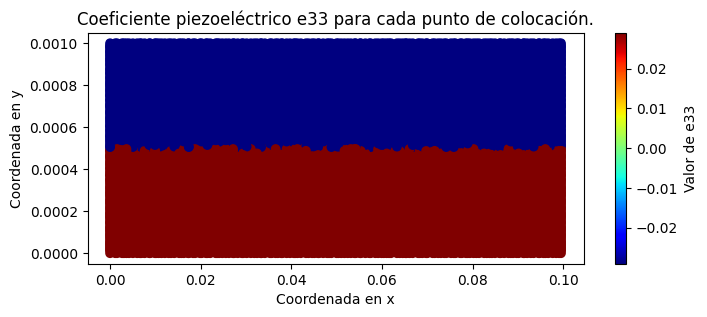

In [68]:
plt.figure(figsize=(8, 3))
sc = plt.scatter(x_collocation[:, 0], y_collocation[:, 0], c=coefficients[:, 6], cmap='jet')
cbar = plt.colorbar(sc)
cbar.set_label('Valor de e33')  # Añadir etiqueta a la barra de color
plt.xlabel('Coordenada en x')
plt.ylabel('Coordenada en y')
plt.title('Coeficiente piezoeléctrico e33 para cada punto de colocación.')
plt.show()

In [69]:
x_collocation = tensorize(x_collocation)
y_collocation = tensorize(y_collocation)
coefficients = tensorize(coefficients)
xy_top = tensorize(xy_top)
xy_bottom = tensorize(xy_bottom)
xy_right = tensorize(xy_right)
xy_left = tensorize(xy_left)

x_collocation = x_collocation.to(device)
y_collocation = y_collocation.to(device)
coefficients = coefficients.to(device)
xy_top = xy_top.to(device)
xy_bottom = xy_bottom.to(device)
xy_right = xy_right.to(device)
xy_left = xy_left.to(device)

xy_left.shape

torch.Size([148, 2])

In [70]:
x_collocation.shape, y_collocation.shape

(torch.Size([22500, 1]), torch.Size([22500, 1]))

### Pérdidas de red neuronal

In [ ]:
def physics_loss(x, y, model):
    x_data = x
    y_data = y
    data = torch.hstack((x_data, y_data))
    y_hat = model(data)

    # Separar las salidas de la red neuronal
    u_pred = y_hat[:, 0:1]
    v_pred = y_hat[:, 1:2]
    phi_pred = y_hat[:, 2:3]
    sigmax_pred = y_hat[:, 3:4]
    sigmaz_pred = y_hat[:, 4:5]
    tauxz_pred = y_hat[:, 5:6]
    Dx_pred = y_hat[:, 6:7]
    Dy_pred = y_hat[:, 7:8]

    # Calcular las derivadas de las salidas de la red neuronal
    ux = torch.autograd.grad(outputs=u_pred, inputs=x_data, grad_outputs=torch.ones_like(u_pred), create_graph=True, retain_graph=True)[0]
    uy = torch.autograd.grad(outputs=u_pred, inputs=y_data, grad_outputs=torch.ones_like(u_pred), create_graph=True, retain_graph=True)[0]

    vx = torch.autograd.grad(outputs=v_pred, inputs=x_data, grad_outputs=torch.ones_like(v_pred), create_graph=True, retain_graph=True)[0]
    vy = torch.autograd.grad(outputs=v_pred, inputs=y_data, grad_outputs=torch.ones_like(v_pred), create_graph=True, retain_graph=True)[0]

    phix = torch.autograd.grad(outputs=phi_pred, inputs=x_data, grad_outputs=torch.ones_like(phi_pred), create_graph=True, retain_graph=True)[0]
    phiy = torch.autograd.grad(outputs=phi_pred, inputs=y_data, grad_outputs=torch.ones_like(phi_pred), create_graph=True, retain_graph=True)[0]

    sigmax_pred_x = torch.autograd.grad(outputs=sigmax_pred, inputs=x_data, grad_outputs=torch.ones_like(sigmax_pred), create_graph=True, retain_graph=True)[0]
    tauxz_pred_y = torch.autograd.grad(outputs=tauxz_pred, inputs=y_data, grad_outputs=torch.ones_like(tauxz_pred), create_graph=True, retain_graph=True)[0]
    tauxz_pred_x = torch.autograd.grad(outputs=tauxz_pred, inputs=x_data, grad_outputs=torch.ones_like(tauxz_pred), create_graph=True, retain_graph=True)[0]
    sigmaz_pred_y = torch.autograd.grad(outputs=sigmaz_pred, inputs=y_data, grad_outputs=torch.ones_like(sigmaz_pred), create_graph=True, retain_graph=True)[0]

    Dx_pred_x = torch.autograd.grad(outputs=Dx_pred, inputs=x_data, grad_outputs=torch.ones_like(Dx_pred), create_graph=True, retain_graph=True)[0]
    Dy_pred_y = torch.autograd.grad(outputs=Dy_pred, inputs=y_data, grad_outputs=torch.ones_like(Dy_pred), create_graph=True, retain_graph=True)[0]

    # Calcular las deformaciones y los campos eléctricos en base a las derivadas de las salidas de la red neuronal
    epsilon_xx = ux
    epsilon_yy = vy
    epsilon_xy = 0.5 * (uy + vx)

    Ex = -phix
    Ey = -phiy

    # Separar los coeficientes del material
    C11 = coefficients[:, 0:1]
    C12 = coefficients[:, 1:2]
    C22 = coefficients[:, 2:3]
    G = coefficients[:, 3:4]
    epsilon1 = coefficients[:, 4:5]
    epsilon2 = coefficients[:, 5:6]
    e31 = coefficients[:, 6:7]
    e33 = coefficients[:, 7:8]

    # Calcular las tensiones y los campos eléctricos en base a las deformaciones y los campos eléctricos
    # acorde a las ecuaciones constitutivas piezoeléctricas
    sigmax = (C11 * epsilon_xx + C12 * epsilon_yy - e31 * Ey)
    sigmaz = (C12 * epsilon_xx + C22 * epsilon_yy - e33 * Ey)
    tauxz = G * epsilon_xy

    Dx = epsilon1 * Ex
    Dy = (e31 * epsilon_xx + e33 * epsilon_yy + epsilon2 * Ey)

    # Calcular las divergencias de los campos de tensiones y campos eléctricos
    divergence_sigma1 = sigmax_pred_x + tauxz_pred_y
    divergence_sigma2 = tauxz_pred_x + sigmaz_pred_y

    divergence_D = Dx_pred_x + Dy_pred_y

    # Asegurar que el estrés y el desplazamiento eléctrico modelados por la red neuronal
    # satisfacen las ecuaciones constitutivas piezoeléctricas
    residual_sigmax = sigmax_pred - sigmax
    residual_sigmaz = sigmaz_pred - sigmaz
    residual_tauxz = tauxz_pred - tauxz

    residual_Dx = Dx_pred - Dx
    residual_Dy = Dy_pred - Dy

    # Unir todas las ecuaciones de equilibrio y las ecuaciones constitutivas
    loss_mech = torch.mean(residual_sigmax**2) + \
                        torch.mean(residual_sigmaz**2) + \
                        torch.mean(residual_tauxz**2)

    loss_elec = torch.mean(residual_Dx**2) + torch.mean(residual_Dy**2)

    loss_divergence = torch.mean((divergence_sigma1)**2) + torch.mean((divergence_sigma2)**2) + torch.mean((divergence_D)**2)


    return loss_mech + loss_elec + loss_divergence

In [73]:
torch.set_printoptions(profile="default")
coefficients

tensor([[ 2.1836e+09,  6.3326e+08,  2.1836e+09,  ..., -1.0406e-10,
         -2.9042e-02, -5.1578e-02],
        [ 2.1836e+09,  6.3326e+08,  2.1836e+09,  ..., -1.0406e-10,
         -2.9042e-02, -5.1578e-02],
        [ 2.1836e+09,  6.3326e+08,  2.1836e+09,  ..., -1.0406e-10,
          2.9042e-02,  5.1578e-02],
        ...,
        [ 2.1836e+09,  6.3326e+08,  2.1836e+09,  ..., -1.0406e-10,
          2.9042e-02,  5.1578e-02],
        [ 2.1836e+09,  6.3326e+08,  2.1836e+09,  ..., -1.0406e-10,
          2.9042e-02,  5.1578e-02],
        [ 2.1836e+09,  6.3326e+08,  2.1836e+09,  ..., -1.0406e-10,
          2.9042e-02,  5.1578e-02]], device='cuda:0', requires_grad=True)

In [ ]:
# Función de pérdida para condición de frontera de estrés
def stress_BC_loss(xy_top, xy_bottom, xy_right, xy_left, model):
    y_hat_right = model(xy_right)

    # Se obtiene el estrés para la parte derecha del dominio
    sigmax_pred_right = y_hat_right[:, 3:4]
    sigmaz_pred_right = y_hat_right[:, 4:5]
    tauxz_pred_right = y_hat_right[:, 5:6]

    # Se genera el vector normal a la frontera derecha
    n_right = torch.ones_like(xy_right)
    n_right[:, 1] = 0

    # Se calcula la tracción en la frontera derecha
    traction_x_right = sigmax_pred_right * n_right[:, 0:1] + tauxz_pred_right * n_right[:, 1:2]
    traction_y_right = tauxz_pred_right * n_right[:, 0:1] + sigmaz_pred_right * n_right[:, 1:2]

    return torch.mean(traction_x_right**2) + torch.mean(traction_y_right**2)

In [ ]:
# Función de pérdida para condición de frontera de desplazamiento eléctrico
def electric_BC_loss(xy_right, xy_left, model):
  y_hat_right = model(xy_right)
  y_hat_left = model(xy_left)

  # Se obtiene el desplazamiento eléctrico para la parte derecha del dominio
  Dx_pred_right = y_hat_right[:, 6:7]
  Dy_pred_right = y_hat_right[:, 7:8]

  # Se obtiene el desplazamiento eléctrico para la parte izquierda del dominio
  Dx_pred_left = y_hat_left[:, 6:7]
  Dy_pred_left = y_hat_left[:, 7:8]

  # Se genera el vector normal a la frontera derecha
  n_right = torch.ones_like(xy_right)
  n_right[:, 1] = 0

  # Se genera el vector normal a la frontera izquierda
  n_left = torch.ones_like(xy_left)
  n_left[:, 1] = 0
  n_left[:, 0] = -1

  # Se calcula el producto punto entre el desplazamiento eléctrico y el vector normal
  D_dot_n_right = Dx_pred_right * n_right[:, 0:1] + Dy_pred_right * n_right[:, 1:2]
  D_dot_n_left = Dx_pred_left * n_left[:, 0:1] + Dy_pred_left * n_left[:, 1:2]

  return torch.mean(D_dot_n_right**2) + torch.mean(D_dot_n_left**2)

In [ ]:
# Función de pérdida para condiciones de frontera
def get_BC_loss(xy_top, xy_bottom, xy_right, xy_left):
    stress_loss_term = stress_BC_loss(xy_top, xy_bottom, xy_right, xy_left, model)
    electric_loss_term = electric_BC_loss(xy_right, xy_left, model)

    return stress_loss_term + electric_loss_term

In [ ]:
# Función de pérdida total
def loss_func(xy_top, xy_bottom, xy_right, xy_left, x_collocation, y_collocation, model, loss_weights, n, f, adjust=False):
    BC_term = get_BC_loss(xy_top, xy_bottom, xy_right, xy_left)
    physics_loss_term = physics_loss(x_collocation, y_collocation, model)

    lambda1 = loss_weights['bc']
    lambda3 = loss_weights['pde']

    loss = lambda1 * BC_term + lambda3 * physics_loss_term
    return loss, loss_weights

### Entrenamiento de red neuronal

In [79]:
epochs_ADAM = 1000
epochs_LBFGS = 200
total_epochs = 1 * (epochs_ADAM + epochs_LBFGS)

In [80]:
optimizer_ADAM = torch.optim.Adam(params=model.parameters(), lr=0.001)
optimizer_LBFGS = torch.optim.LBFGS(params=model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ADAM, step_size=100, gamma=0.9, verbose=False)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
# Registro de experimento en MLflow
mlflow.start_run()
mlflow.log_param("epochs_ADAM", epochs_ADAM)
mlflow.log_param("epochs_LBFGS", epochs_LBFGS)
mlflow.log_param("learning_rate_ADAM", optimizer_ADAM.state_dict()['param_groups'][0]['lr'])
mlflow.log_param("learning_rate_LBFGS", optimizer_LBFGS.state_dict()['param_groups'][0]['lr'])

0.01

In [82]:
loss_list = []

In [83]:
loss_weights = {'pde': 1.0, 'bc': 1.0}

In [84]:
f = 500

In [85]:
checkpoints_ADAM = root + 'checkpoints_ADAM/'
best_loss_ADAM = float('inf')

In [86]:
start_time = time.time()

In [87]:
for epoch in range(epochs_ADAM):
    optimizer_ADAM.zero_grad()
    loss, loss_weights = loss_func(xy_top, xy_bottom, xy_right, xy_left, x_collocation, y_collocation, model, loss_weights, epoch, f)
    loss.backward()
    optimizer_ADAM.step()
    loss_list.append(loss.item())
    # scheduler.step()

    if epoch % 100 == 0:
        print(f"Epoch: {epoch}/{total_epochs}. Loss: {loss.item()}.")
        print(optimizer_ADAM.state_dict()['param_groups'][0]['lr'])
        mlflow.log_metric("loss_ADAM", loss.item(), step=epoch)

        # Guardar el modelo si la pérdida es la mejor hasta el momento
        if loss.item() < best_loss_ADAM:
            best_loss_ADAM = loss.item()
            checkpoint_path = os.path.join(checkpoints_ADAM, f"model_epoch_{epoch}_loss_{best_loss_ADAM:.4f}.pt")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer_ADAM.state_dict(),
                'loss': loss.item(),
                'loss_weights': loss_weights,
            }, checkpoint_path)
            print(f"Checkpoint saved at epoch {epoch} with loss {best_loss_ADAM:.4f}")

    if epoch % f == 0:
      print(f"Lambda_1: {loss_weights}.")

Epoch: 0/1200. Loss: 1000188294463488.0.
0.001
Checkpoint saved at epoch 0 with loss 1000188294463488.0000
Lambda_1: {'pde': 1.0, 'bc': 1.0}.
Epoch: 100/1200. Loss: 1480829173760.0.
0.001
Checkpoint saved at epoch 100 with loss 1480829173760.0000
Epoch: 200/1200. Loss: 1155764096.0.
0.001
Checkpoint saved at epoch 200 with loss 1155764096.0000
Epoch: 300/1200. Loss: 26571550.0.
0.001
Checkpoint saved at epoch 300 with loss 26571550.0000
Epoch: 400/1200. Loss: 26275874.0.
0.001
Checkpoint saved at epoch 400 with loss 26275874.0000
Epoch: 500/1200. Loss: 26268454.0.
0.001
Checkpoint saved at epoch 500 with loss 26268454.0000
Lambda_1: {'pde': 1.0, 'bc': 1.0}.
Epoch: 600/1200. Loss: 26266034.0.
0.001
Checkpoint saved at epoch 600 with loss 26266034.0000
Epoch: 700/1200. Loss: 26264056.0.
0.001
Checkpoint saved at epoch 700 with loss 26264056.0000
Epoch: 800/1200. Loss: 26262488.0.
0.001
Checkpoint saved at epoch 800 with loss 26262488.0000
Epoch: 900/1200. Loss: 26260596.0.
0.001
Checkpoi

In [88]:
loss_weights

{'pde': 1.0, 'bc': 1.0}

In [89]:
checkpoints_dir = root + 'checkpoints_LBFGS2/'
best_loss = float('inf')

In [90]:
from math import nan
for epoch in range(epochs_LBFGS):
    def closure():
        global loss_weights, epoch, f
        # Limpiar los gradientes antes de calcular la pérdida
        optimizer_LBFGS.zero_grad()
        # Calcular la pérdida
        loss, loss_weights = loss_func(xy_top, xy_bottom, xy_right, xy_left, x_collocation, y_collocation, model, loss_weights, epoch, f)
        # Realizar el paso hacia atrás
        loss.backward()
        # Retornar la pérdida para que LBFGS pueda usarla
        return loss

    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)

    optimizer_LBFGS.step(closure)

    loss = closure()

    loss_list.append(loss.item())

    if loss.item() == nan:
      print('nan')
      break

    if epoch % 100 == 0 or epoch == epochs_LBFGS - 1:
        print(f"Epoch: {epochs_ADAM + epoch}/{total_epochs}. Loss: {loss.item()}.")
        mlflow.log_metric("loss_LBFGS", loss.item(), step=epochs_ADAM + epoch)

    # Guardar el modelo si la pérdida es la mejor hasta el momento
    if loss.item() < best_loss:
        best_loss = loss.item()
        checkpoint_path = os.path.join(checkpoints_dir, f"model_epoch_{epoch}_loss_{best_loss:.4f}.pt")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer_LBFGS.state_dict(),
            'loss': loss.item(),
            'loss_weights': loss_weights,
        }, checkpoint_path)
        # print(f"Checkpoint saved at epoch {epoch} with loss {best_loss:.4f}")


Epoch: 1000/1200. Loss: 13997562880.0.
Epoch: 1100/1200. Loss: 26348838.0.
Epoch: 1199/1200. Loss: 21927810.0.


In [91]:
end_time = time.time()
total_time = end_time - start_time

mlflow.log_metric("total_training_time_seconds", total_time)

In [92]:
mlflow.log_param("final_loss", best_loss)
mlflow.log_metric("final_epoch", epoch)

Graph temporarily saved at /tmp/tmptjl08p41.png
Graph logged to MLflow as artifact loss


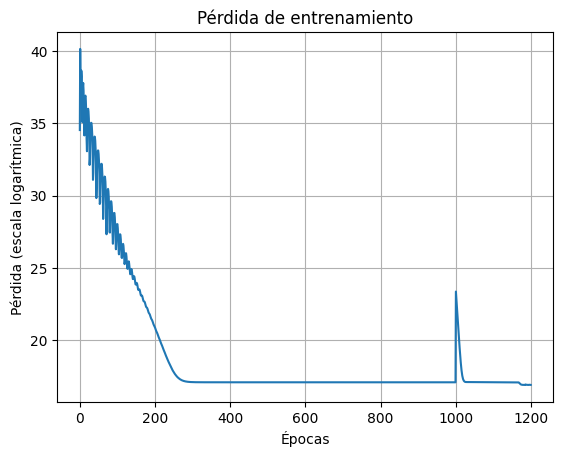

In [93]:
plt.figure()
log_loss = np.log(loss_list)
plt.plot(log_loss)
plt.xlabel('Épocas')
plt.ylabel('Pérdida (escala logarítmica)')
plt.title('Pérdida de entrenamiento')
plt.grid(True)

with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as tmpfile:
    plt.savefig(tmpfile.name, format='png', dpi=300)
    print(f"Graph temporarily saved at {tmpfile.name}")

    mlflow.log_artifact(tmpfile.name, artifact_path="plots")
    print(f"Graph logged to MLflow as artifact loss")

plt.show()

### Evaluación de PINN en puntos de prueba

In [ ]:
x_test = np.load(root + 'x_collocation_test_non_normalized_m1.npy')
x_test = x_test[:, :2]
x_test = tensorize(x_test)
x_test.shape

torch.Size([40000, 2])

In [97]:
preds = model(x_test ).detach().cpu().numpy()
u_pred = preds[:, 0]
v_pred = preds[:, 1]
phi_pred = preds[:, 2]
sigmax_pred = preds[:, 3]
sigmaz_pred = preds[:, 4]
tauxz_pred = preds[:, 5]
Dx_pred = preds[:, 6]
Dy_pred = preds[:, 7]

In [ ]:
x_test = x_test.detach().cpu().numpy()

In [ ]:
# Función para graficar los resultados y guardarlos en experimento de MLflow
def plot_results(x, y, value, title, filename, xlabel='x', ylabel='y', colorbar_label='Value', save=True):
    plt.figure(figsize=(12, 3))
    plt.title(title)

    # Creación del scatter plot
    scatter = plt.scatter(x, y, c=value, cmap='jet')

    # Agregar nombres a los ejes
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Añadir la barra de colores y el nombre de la escala
    cbar = plt.colorbar(scatter)
    cbar.set_label(colorbar_label)

    if save:
        with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as tmpfile:
            plt.savefig(tmpfile.name, format='png', dpi=300)
            print(f"Graph temporarily saved at {tmpfile.name}")

            # Registra el gráfico en MLflow
            mlflow.log_artifact(tmpfile.name, artifact_path="plots")
            print(f"Graph logged to MLflow as artifact {filename}")

    plt.show()

Graph temporarily saved at /tmp/tmpc9lz8jnq.png
Graph logged to MLflow as artifact u_displacement_plot.png


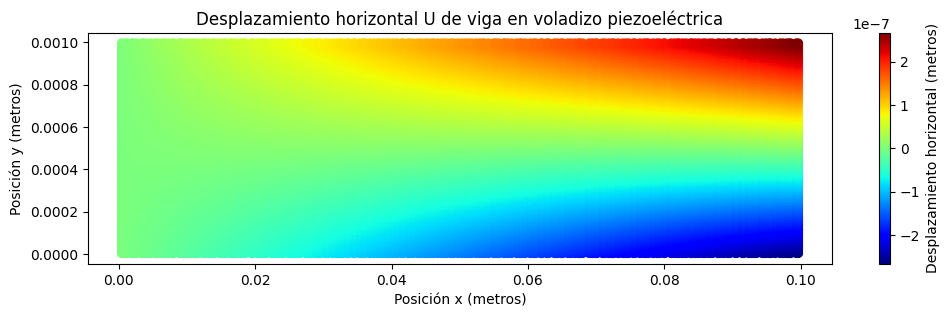

In [100]:
filename = "u_displacement_plot.png"
plot_results(x_test[:, 0], x_test[:, 1], u_pred,
             title='Desplazamiento horizontal U de viga en voladizo piezoeléctrica',
             filename=filename,
             xlabel='Posición x (metros)',
             ylabel='Posición y (metros)',
             colorbar_label='Desplazamiento horizontal (metros)')

Graph temporarily saved at /tmp/tmpkxzkzsb9.png
Graph logged to MLflow as artifact v_displacement_plot.png


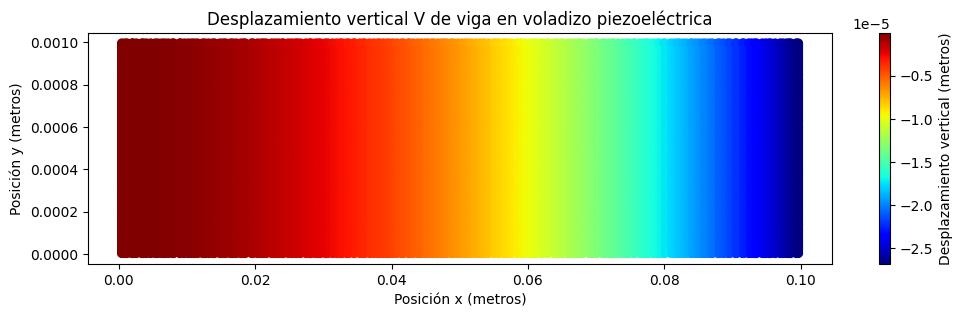

In [101]:
filename = "v_displacement_plot.png"
plot_results(x_test[:, 0], x_test[:, 1], v_pred,
             title='Desplazamiento vertical V de viga en voladizo piezoeléctrica',
             filename=filename,
             xlabel='Posición x (metros)',
             ylabel='Posición y (metros)',
             colorbar_label='Desplazamiento vertical (metros)')

Graph temporarily saved at /tmp/tmpgaf1gb4c.png
Graph logged to MLflow as artifact phi_plot.png


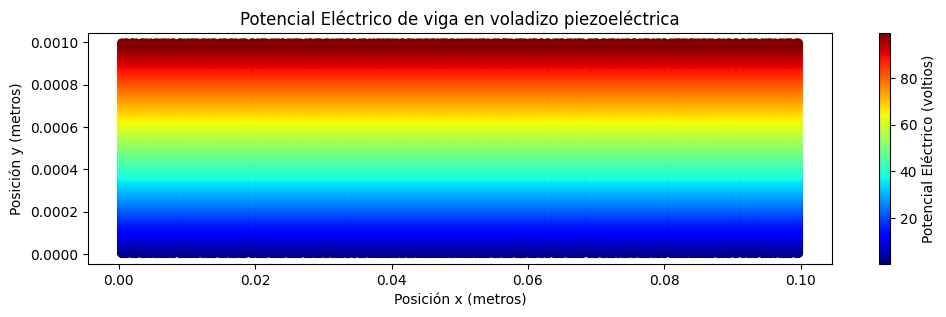

In [102]:
filename = "phi_plot.png"
plot_results(x_test[:, 0], x_test[:, 1], phi_pred,
             title='Potencial Eléctrico de viga en voladizo piezoeléctrica',
             filename=filename,
             xlabel='Posición x (metros)',
             ylabel='Posición y (metros)',
             colorbar_label='Potencial Eléctrico (voltios)')

#### Grafica de desplazamiento de viga

Graph temporarily saved at /tmp/tmpc20t02hd.png
Graph logged to MLflow as artifact.


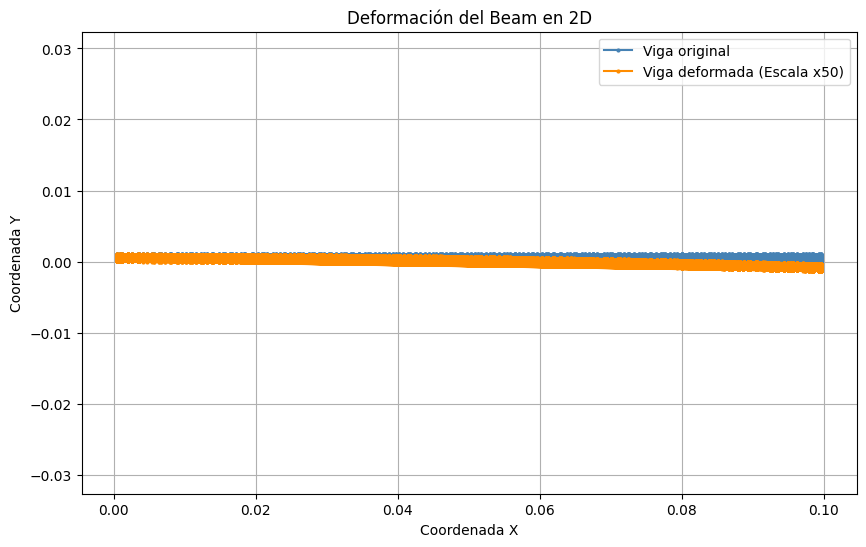

In [104]:
scale_factor = 50  # Ajusta este valor según sea necesario

# Extraer coordenadas iniciales
x_coords = x_test[:, 0]
y_coords = x_test[:, 1]

# Coordenadas deformadas con escala aplicada
x_deformed = x_coords + scale_factor * u_pred
y_deformed = y_coords + scale_factor * v_pred

# Graficar la viga original y la deformada
plt.figure(figsize=(10, 6))

# Plot de la viga original
plt.plot(x_coords, y_coords, color='steelblue', marker='o', linestyle='-', label='Viga original', markersize=2)

# Plot de la viga deformada
plt.plot(x_deformed, y_deformed, color='darkorange', marker='o', linestyle='-', label='Viga deformada (Escala x{})'.format(scale_factor), markersize=2)

# Configuración del gráfico
plt.title('Deformación del Beam en 2D')
plt.xlabel('Coordenada X')
plt.ylabel('Coordenada Y')
plt.legend()
plt.grid(True)
plt.axis('equal')  # Escala igual para evitar distorsión

with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as tmpfile:
    # Guardar el gráfico en el archivo temporal
    plt.savefig(tmpfile.name, format='png', dpi=300)
    print(f"Graph temporarily saved at {tmpfile.name}")

    # Registra el gráfico en MLflow como un artefacto
    mlflow.log_artifact(tmpfile.name, artifact_path="plots")
    print(f"Graph logged to MLflow as artifact.")

# Mostrar el gráfico
plt.show()

### Comparación con FEM

In [ ]:
# Se leen los datos de FEM
ground_truth = pd.read_csv(root + 'FEM.csv')
X_ground_truth = ground_truth['X_Coordinate'].values
Y_ground_truth = ground_truth['Y_Coordinate'].values
U = ground_truth['X_Deflection'].values
V = ground_truth['Y_Deflection'].values
Phi_ground_truth = ground_truth['Potential'].values

In [111]:
X_ground_truth = X_ground_truth.reshape(-1, 1)
Y_ground_truth = Y_ground_truth.reshape(-1, 1)

In [112]:
X_ground_truth = np.hstack((X_ground_truth, Y_ground_truth))
X_ground_truth_tensor = tensorize(X_ground_truth)

In [ ]:
# Predicción de la red neuronal para los puntos en los que se evaluó FEM
preds_gr = model(X_ground_truth_tensor).detach().cpu().numpy()
u_pred_gr = preds_gr[:, 0]
v_pred_gr = preds_gr[:, 1]
phi_pred_gr = preds_gr[:, 2]

#### Cálculo de error L2 norm

In [114]:
l2_norm_u = np.linalg.norm(U - u_pred_gr)
l2_norm_v = np.linalg.norm(V - v_pred_gr)
l2_norm_phi = np.linalg.norm(Phi_ground_truth - phi_pred_gr)

print("L2 Norm for U:", l2_norm_u)
print("L2 Norm for V:", l2_norm_v)
print("L2 Norm for Phi:", l2_norm_phi)

L2 Norm for U: 7.919531406912011e-07
L2 Norm for V: 8.549924075108198e-05
L2 Norm for Phi: 2.7307872571216114


In [115]:
mlflow.log_metric("L2_Norm_U", l2_norm_u)
mlflow.log_metric("L2_Norm_V", l2_norm_v)
mlflow.log_metric("L2_Norm_Phi", l2_norm_phi)

#### Visualización de resultados esperados con FEM

Graph temporarily saved at /tmp/tmpzf758crp.png
Graph logged to MLflow as artifact u_displacement_plot.png


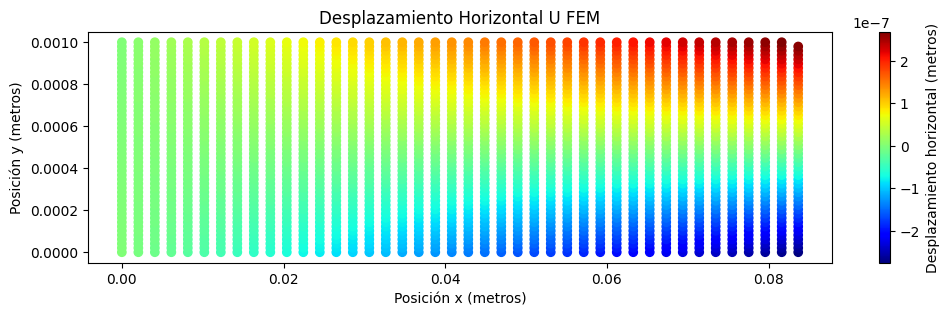

In [116]:
filename = "u_displacement_plot.png"
plot_results(X_ground_truth[:, 0], X_ground_truth[:, 1], U,
             title='Desplazamiento Horizontal U FEM',
             filename=filename,
             xlabel='Posición x (metros)',
             ylabel='Posición y (metros)',
             colorbar_label='Desplazamiento horizontal (metros)')

Graph temporarily saved at /tmp/tmpzbsw70oa.png
Graph logged to MLflow as artifact u_displacement_plot.png


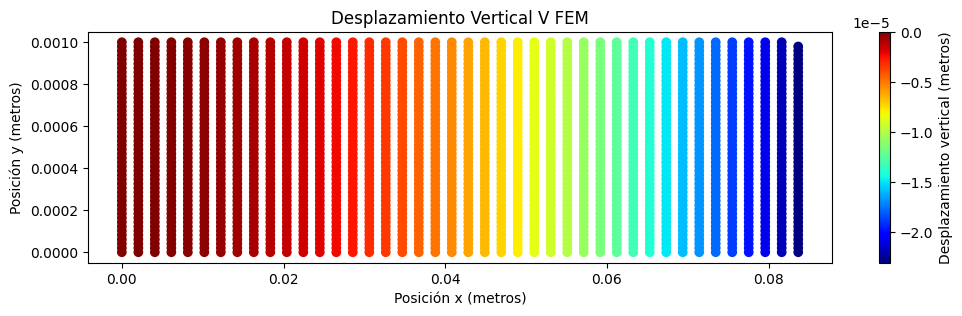

In [117]:
filename = "u_displacement_plot.png"
plot_results(X_ground_truth[:, 0], X_ground_truth[:, 1], V,
             title='Desplazamiento Vertical V FEM',
             filename=filename,
             xlabel='Posición x (metros)',
             ylabel='Posición y (metros)',
             colorbar_label='Desplazamiento vertical (metros)')

Graph temporarily saved at /tmp/tmpyb61ken3.png
Graph logged to MLflow as artifact u_displacement_plot.png


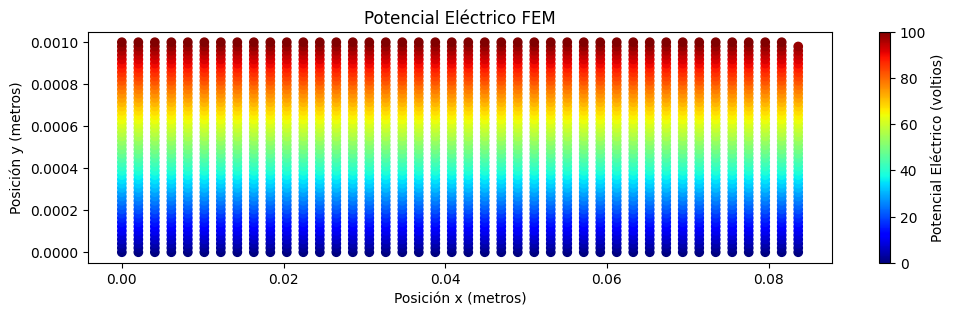

In [118]:
plot_results(X_ground_truth[:, 0], X_ground_truth[:, 1], Phi_ground_truth,
             title='Potencial Eléctrico FEM',
             filename=filename,
             xlabel='Posición x (metros)',
             ylabel='Posición y (metros)',
             colorbar_label='Potencial Eléctrico (voltios)')

Graph temporarily saved at /tmp/tmpanmctwoq.png
Graph logged to MLflow as artifact.


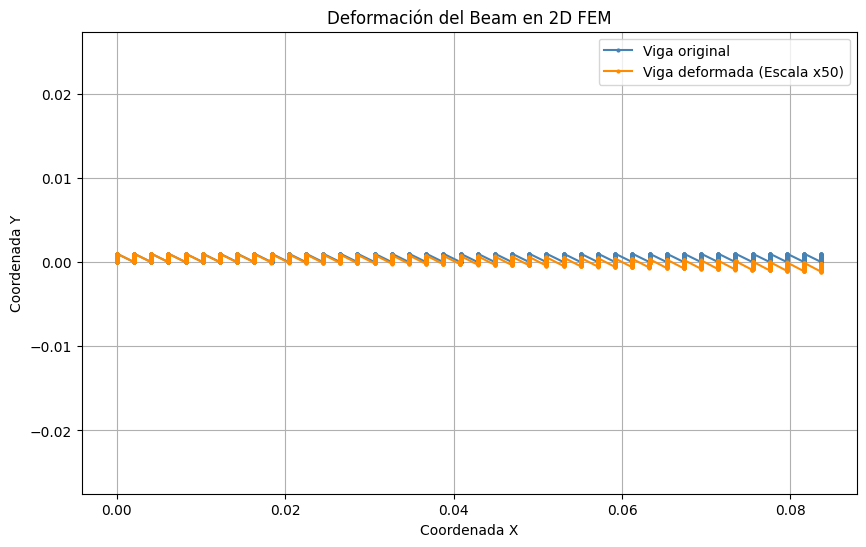

In [119]:
scale_factor = 50  # Ajusta este valor según sea necesario

# Extraer coordenadas iniciales
x_coords = X_ground_truth[:, 0]
y_coords = X_ground_truth[:, 1]

# Coordenadas deformadas con escala aplicada
x_deformed = x_coords + scale_factor * U
y_deformed = y_coords + scale_factor * V

# Graficar la viga original y la deformada
plt.figure(figsize=(10, 6))

# Plot de la viga original
plt.plot(x_coords, y_coords, color='steelblue', marker='o', linestyle='-', label='Viga original', markersize=2)

# Plot de la viga deformada
plt.plot(x_deformed, y_deformed, color='darkorange', marker='o', linestyle='-', label='Viga deformada (Escala x{})'.format(scale_factor), markersize=2)

# Configuración del gráfico
plt.title('Deformación del Beam en 2D FEM')
plt.xlabel('Coordenada X')
plt.ylabel('Coordenada Y')
plt.legend()
plt.grid(True)
plt.axis('equal')  # Escala igual para evitar distorsión

with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as tmpfile:
    # Guardar el gráfico en el archivo temporal
    plt.savefig(tmpfile.name, format='png', dpi=300)
    print(f"Graph temporarily saved at {tmpfile.name}")

    # Registra el gráfico en MLflow como un artefacto
    mlflow.log_artifact(tmpfile.name, artifact_path="plots")
    print(f"Graph logged to MLflow as artifact.")

# Mostrar el gráfico
plt.show()

#### Error absoluto entre FEM y PINN

In [122]:
u_error = np.abs(U - u_pred_gr)
v_error = np.abs(V - v_pred_gr)
phi_error = np.abs(Phi_ground_truth - phi_pred_gr)

Graph temporarily saved at /tmp/tmp7th6ssid.png
Graph logged to MLflow as artifact u_error_plot.png


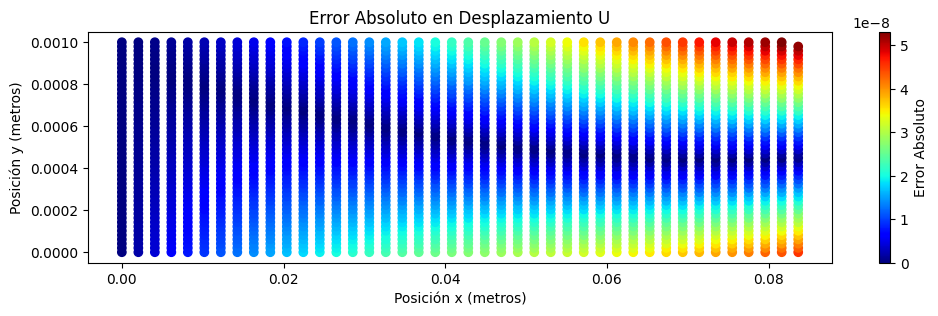

In [123]:
# Graficar el error absoluto para U
plot_results(X_ground_truth[:, 0], X_ground_truth[:, 1], u_error,
             title='Error Absoluto en Desplazamiento U',
             filename='u_error_plot.png',
             xlabel='Posición x (metros)',
             ylabel='Posición y (metros)',
             colorbar_label='Error Absoluto')

Graph temporarily saved at /tmp/tmpyu_18xfa.png
Graph logged to MLflow as artifact v_error_plot.png


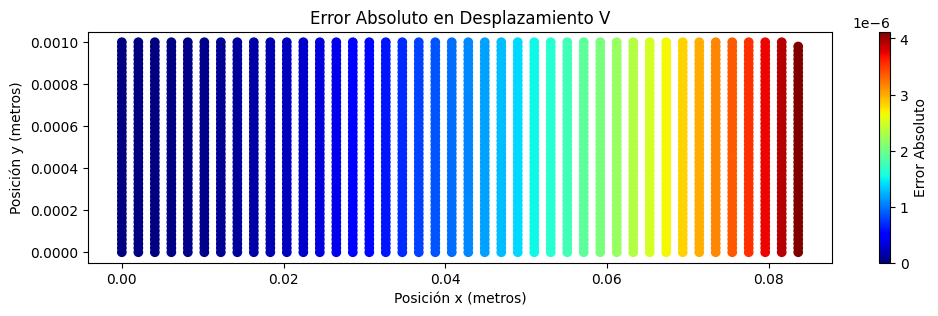

In [124]:
# Graficar el error absoluto para U
plot_results(X_ground_truth[:, 0], X_ground_truth[:, 1], v_error,
             title='Error Absoluto en Desplazamiento V',
             filename='v_error_plot.png',
             xlabel='Posición x (metros)',
             ylabel='Posición y (metros)',
             colorbar_label='Error Absoluto')

Graph temporarily saved at /tmp/tmppg962alq.png
Graph logged to MLflow as artifact phi_error_plot.png


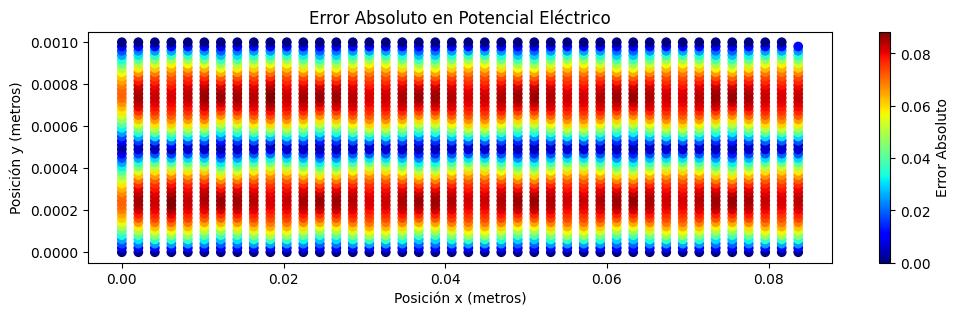

In [125]:
# Graficar el error absoluto para U
plot_results(X_ground_truth[:, 0], X_ground_truth[:, 1], phi_error,
             title='Error Absoluto en Potencial Eléctrico',
             filename='phi_error_plot.png',
             xlabel='Posición x (metros)',
             ylabel='Posición y (metros)',
             colorbar_label='Error Absoluto')

In [128]:
current_seed = torch.initial_seed()

print(f"Semilla actual: {current_seed}")

Semilla actual: 14626642297805549986


In [129]:
mlflow.log_param("seed", current_seed)

14626642297805549986

In [130]:
mlflow.end_run()

2024/10/20 01:53:02 INFO mlflow.tracking._tracking_service.client: 🏃 View run nebulous-bat-819 at: https://dagshub.com/danielgo.carrillo/Grad.mlflow/#/experiments/0/runs/7c5336dcdc3649d2bab4d977fa7b49df.
2024/10/20 01:53:02 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/danielgo.carrillo/Grad.mlflow/#/experiments/0.
